Alumno: Milton Aldair Martínez Acosta  

Matrícula: 1870354

Estadística Aplicada

Grupo: 051

# Modelo ETS

## Error Trend Seasonality

## Irregular Tendencia Estacionalidad

Statsmodels proporciona una herramienta de descomposición estacional que podemos usar para separar los diferentes componentes de una serie de tiempo.

Aplicamos un modelo aditivo cuando parece que la tendencia es más lineal y los componentes de estacionalidad y tendencia parecen ser constantes en el tiempo.

Un modelo multiplicativo es más apropiado cuando estamos aumentando (o disminuyendo) a una tasa no lineal.

Para estos ejemplos, usaremos los datos del Indicador Global de la Actividad Económica, que proporciona datos en porcentaje comparado al IGAE del 2013 desde enero de 2010 hasta diciembre de 2021.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
IGAE = pd.read_csv('https://raw.githubusercontent.com/Miltonmtz/Tareas_EstadisticaAplicada_22/main//IGAE.csv',index_col='Periodo mensual',parse_dates=True)

In [ ]:
IGAE.dropna(inplace=True)

In [ ]:
IGAE.head()

,IGAE
Periodo mensual,
2010-01-01,86.87
2010-02-01,85.23
2010-03-01,92.29
2010-04-01,90.58
2010-05-01,92.30


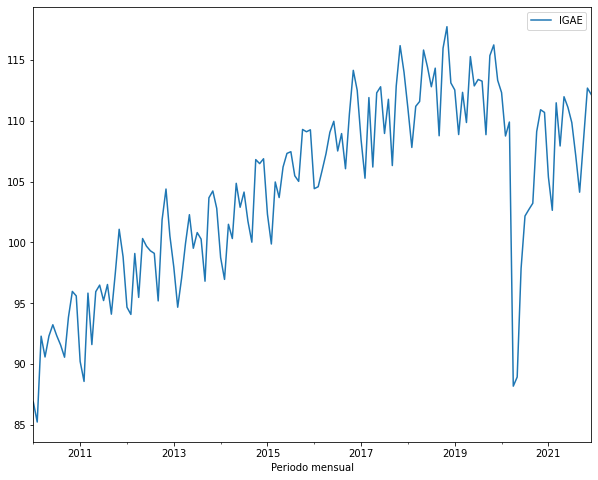

In [ ]:
IGAE.plot(figsize=(10,8));

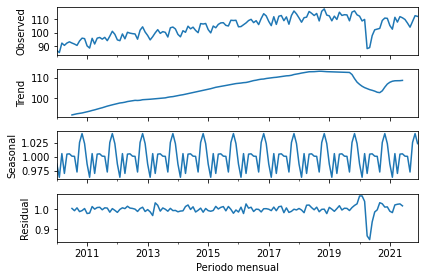

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(IGAE['IGAE'], model='multiplicative')  #mul tambien funciona
result.plot();


In [ ]:
#vamos a obtner la serie desestacionalida
#primero obtenemos el componente estacional al que accedemos con .seasonal del objeto result
componente_estacional = result.seasonal
IGAE['desestacionalizado'] = IGAE['IGAE'] / componente_estacional

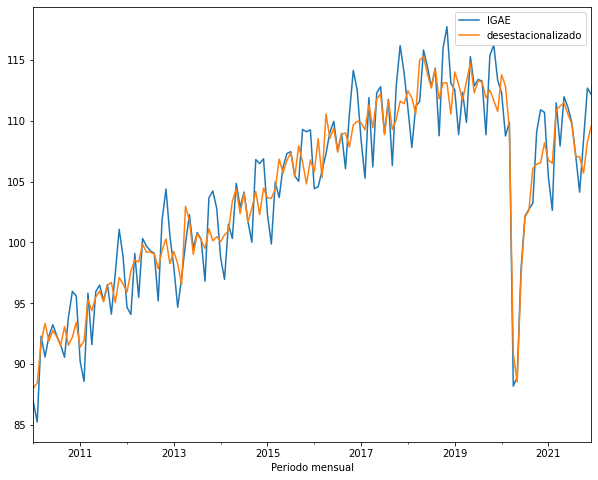

In [ ]:
#graficamos
IGAE[['IGAE','desestacionalizado']].plot(figsize=(10,8));

# Promedio Móvil Simple SMA 
## Simple moving average

In [ ]:
IGAE['PMS-6meses'] = IGAE['IGAE'].rolling(window=6).mean()
IGAE['PMS-12meses'] = IGAE['IGAE'].rolling(window=12).mean()

In [ ]:
IGAE.head(15)

,IGAE,desestacionalizado,PMS-6meses,PMS-12meses
Periodo mensual,,,,
2010-01-01,86.87,88.010363,NaN,NaN
2010-02-01,85.23,88.446569,NaN,NaN
2010-03-01,92.29,91.786819,NaN,NaN
2010-04-01,90.58,93.340239,NaN,NaN
2010-05-01,92.30,91.880809,NaN,NaN
2010-06-01,93.23,92.756610,90.083333,NaN
2010-07-01,92.33,92.243459,90.993333,NaN
2010-08-01,91.56,91.498755,92.048333,NaN
2010-09-01,90.56,93.079435,91.760000,NaN


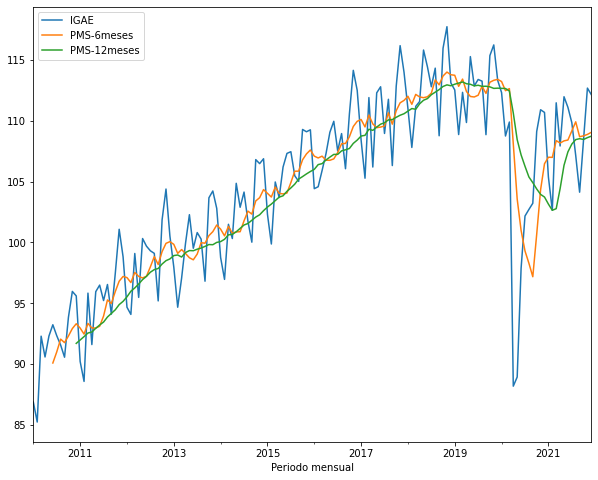

In [ ]:
IGAE[['IGAE','PMS-6meses','PMS-12meses']].plot(figsize=(10,8));

# Promedio Móvil Ponderado Exponencialmente EWMA
## Exponentially Weighted Moving Average

Acabamos de mostrar cómo calcular el PMS para un periodo de tiempo T. Sin embargo, el PMS básico tiene algunas debilidades:
* Periodos de tiempo muy pequeños generarán más ruido, en lugar de  brindarnos una señal de la tendencia de la serie
* Siempre tendra un ajuste hacia atrás 
* Nunca alcanzará el pico o valle completo de los datos debido al promedio.
* Realmente no informa sobre el posible comportamiento futuro de la serie, todo lo que hace es describir la tendencia pasada de los datos.
* Los valores históricos extremos pueden sesgar el PMS

Una alternativa que soluciona o minimiza los problemas anteriores es el EWMA

En python  cuando damos adjust true
### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

cuando damos adjust False
### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

para aplicar EWMA usamos la función EWM

In [ ]:
IGAE['EWMA12'] = IGAE['IGAE'].ewm(span=12,adjust=False).mean()

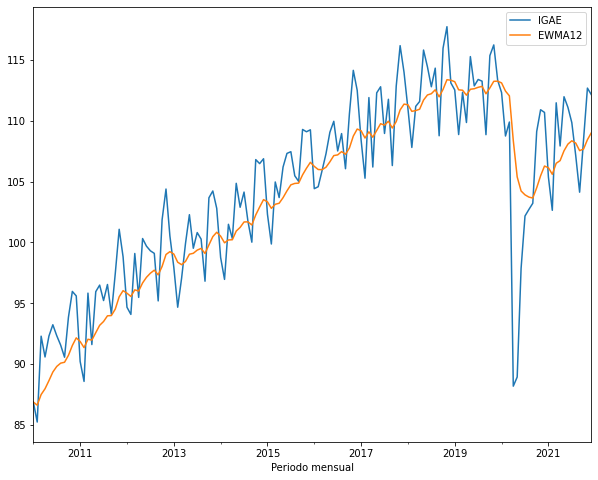

In [ ]:
IGAE[['IGAE','EWMA12']].plot(figsize=(10,8));

## Comparemos PMS to EWMA

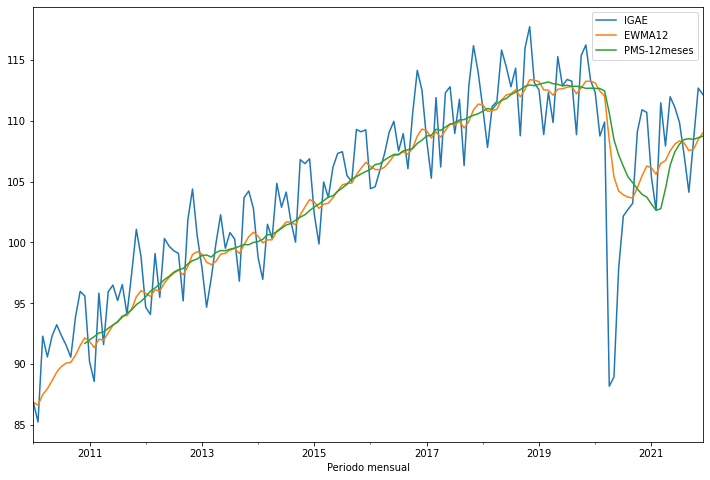

In [ ]:
IGAE[['IGAE','EWMA12','PMS-12meses']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

# Métodos Holt-Winters 

En esta sección, veremos el suavizado exponencial doble y triple con los métodos de Holt-Winters.

En el suavizado exponencial doble (también conocido como método de Holt) presentamos un nuevo factor de suavizado 𝛽 (beta) que aborda la tendencia:
\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    nivel}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    tendencia}\\
y_t &= l_t + b_t & \text{   modelo estimado}\\
\hat y_{t+h} &= l_t + hb_t & \text{    modelo de pronóstico (} h = \text{# periodos futuros)}\end{split}

Debido a que aún no hemos considerado las fluctuaciones estacionales, el modelo de pronóstico es simplemente una línea recta que se extiende desde el punto de datos más reciente.

Con el suavizado exponencial triple (también conocido como el método Holt-Winters) introducimos un factor de suavizado 𝛾 (gamma) que aborda la estacionalidad:
\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    nivel}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    tendencia}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    estacionalidad}\\
y_t &= (l_t + b_t) c_t & \text{    modelo estimado}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    modelo de pronóstico (} m = \text{# periodos futuros)}\end{split}
$L$ representa el número de frecuencia de la serie por periodo. En nuestro caso tenemos datos mensuales, por tanto debemos usar $L=12$.

En general, valores muy grandes de $\alpha$, $\beta$ y $\gamma$, dan mas peso a las observaciones presentes.

Antes de ejecutar el método de holt winters tenemos que establecer la frecuencia de los datos

In [ ]:
IGAE.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Periodo mensual', length=144, freq=None)

note que en **freq** no esta especificado

In [ ]:
IGAE.index.freq = 'MS'
IGAE.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Periodo mensual', length=144, freq='MS')

## Promedio exponencial simple

La función statmodels Holt-Winters nos permite hacer el suavizamiento exponencial simple. es el equivalente al que usamos con pandas  <tt>.ewm()</tt> 

$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)


IGAE['SES12']=SimpleExpSmoothing(IGAE['IGAE']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
IGAE.head()

,IGAE,desestacionalizado,PMS-6meses,PMS-12meses,EWMA12,SES12
Periodo mensual,,,,,,
2010-01-01,86.87,88.010363,NaN,NaN,86.870000,86.870000
2010-02-01,85.23,88.446569,NaN,NaN,86.617692,86.617692
2010-03-01,92.29,91.786819,NaN,NaN,87.490355,87.490355
2010-04-01,90.58,93.340239,NaN,NaN,87.965685,87.965685
2010-05-01,92.30,91.880809,NaN,NaN,88.632503,88.632503


## Double Exponential Smoothing
Donde el suavizado exponencial simple emplea solo un factor de suavizado $\alpha$ (alfa), el suavizado exponencial doble agrega un segundo factor de suavizado $\beta$ (beta) que aborda las tendencias en los datos. Al igual que el factor alfa, los valores del factor beta se encuentran entre cero y uno ($0<\beta≤1$). La ventaja es  que ahora el modelo puede anticipar futuros aumentos o disminuciones.

También podemos abordar diferentes tipos de cambio (crecimiento/decadencia) en la tendencia. Si una serie de tiempo muestra una tendencia inclinada en línea recta, usaría un ajuste <strong>aditivo</strong>. Si la serie temporal muestra una tendencia exponencial (curva), usaría un ajuste <strong>multiplicativo</strong>.

A medida que avanzamos hacia el pronóstico, vale la pena señalar que tanto los ajustes aditivos como los multiplicativos pueden exagerarse con el tiempo y requieren <em>amortiguación</em> que reduce el tamaño de la tendencia en períodos futuros hasta que alcanza una línea plana.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

IGAE['DESadd12'] = ExponentialSmoothing(IGAE['IGAE'], trend='add').fit().fittedvalues.shift(-1)
IGAE.head()

,IGAE,desestacionalizado,PMS-6meses,PMS-12meses,EWMA12,SES12,DESadd12
Periodo mensual,,,,,,,
2010-01-01,86.87,88.010363,NaN,NaN,86.870000,86.870000,87.172071
2010-02-01,85.23,88.446569,NaN,NaN,86.617692,86.617692,86.191476
2010-03-01,92.29,91.786819,NaN,NaN,87.490355,87.490355,89.977456
2010-04-01,90.58,93.340239,NaN,NaN,87.965685,87.965685,90.505343
2010-05-01,92.30,91.880809,NaN,NaN,88.632503,88.632503,91.739932


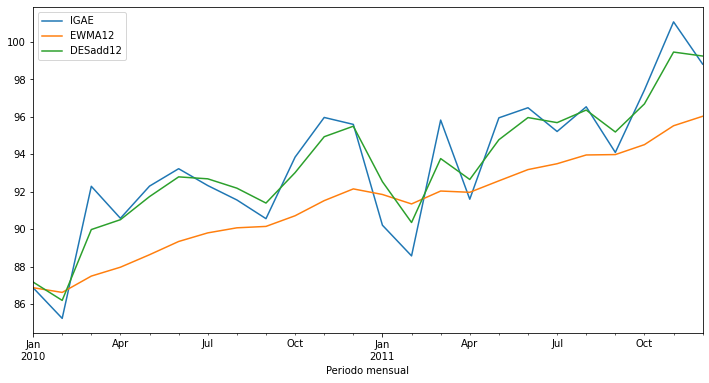

In [ ]:
IGAE[['IGAE','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

podemos ver que el suavizado exponencial doble es una representación mejor de los datos de la serie temporal.

Esto es así por que estamos modelando todos los componentes de la serie

Veamos si usar un ajuste estacional multiplicativo ayuda.

In [ ]:
IGAE['DESmul12'] = ExponentialSmoothing(IGAE['IGAE'], trend='mul').fit().fittedvalues.shift(-1)
IGAE.head()

,IGAE,desestacionalizado,PMS-6meses,PMS-12meses,EWMA12,SES12,DESadd12,DESmul12
Periodo mensual,,,,,,,,
2010-01-01,86.87,88.010363,NaN,NaN,86.870000,86.870000,87.172071,87.032324
2010-02-01,85.23,88.446569,NaN,NaN,86.617692,86.617692,86.191476,86.071564
2010-03-01,92.29,91.786819,NaN,NaN,87.490355,87.490355,89.977456,89.901104
2010-04-01,90.58,93.340239,NaN,NaN,87.965685,87.965685,90.505343,90.426439
2010-05-01,92.30,91.880809,NaN,NaN,88.632503,88.632503,91.739932,91.666164


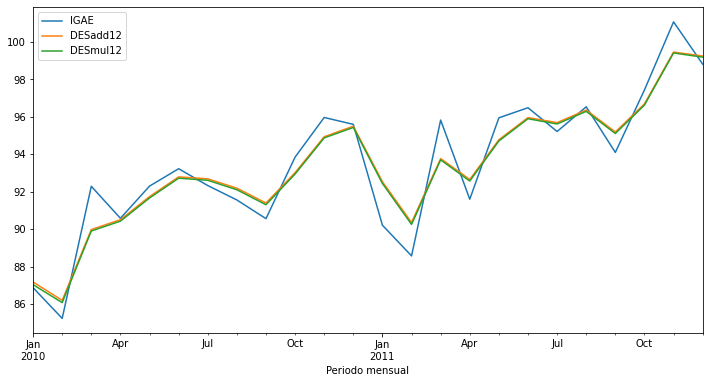

In [ ]:
IGAE[['IGAE','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

## Triple Exponential Smoothing
El suavizado exponencial triple es el método más estrechamente asociado con Holt-Winters, agrega compatibilidad con las tendencias y la estacionalidad de los datos.

In [ ]:
IGAE['TESadd12'] = ExponentialSmoothing(IGAE['IGAE'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
IGAE.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,IGAE,desestacionalizado,PMS-6meses,PMS-12meses,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Periodo mensual,,,,,,,,,
2010-01-01,86.87,88.010363,NaN,NaN,86.870000,86.870000,87.172071,87.032324,88.797162
2010-02-01,85.23,88.446569,NaN,NaN,86.617692,86.617692,86.191476,86.071564,83.987582
2010-03-01,92.29,91.786819,NaN,NaN,87.490355,87.490355,89.977456,89.901104,90.169739
2010-04-01,90.58,93.340239,NaN,NaN,87.965685,87.965685,90.505343,90.426439,90.729258
2010-05-01,92.30,91.880809,NaN,NaN,88.632503,88.632503,91.739932,91.666164,94.700937


In [ ]:
IGAE['TESmul12'] = ExponentialSmoothing(IGAE['IGAE'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
IGAE.head()

,IGAE,desestacionalizado,PMS-6meses,PMS-12meses,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Periodo mensual,,,,,,,,,,
2010-01-01,86.87,88.010363,NaN,NaN,86.870000,86.870000,87.172071,87.032324,88.797162,90.112481
2010-02-01,85.23,88.446569,NaN,NaN,86.617692,86.617692,86.191476,86.071564,83.987582,84.170973
2010-03-01,92.29,91.786819,NaN,NaN,87.490355,87.490355,89.977456,89.901104,90.169739,89.659648
2010-04-01,90.58,93.340239,NaN,NaN,87.965685,87.965685,90.505343,90.426439,90.729258,90.584201
2010-05-01,92.30,91.880809,NaN,NaN,88.632503,88.632503,91.739932,91.666164,94.700937,94.497128


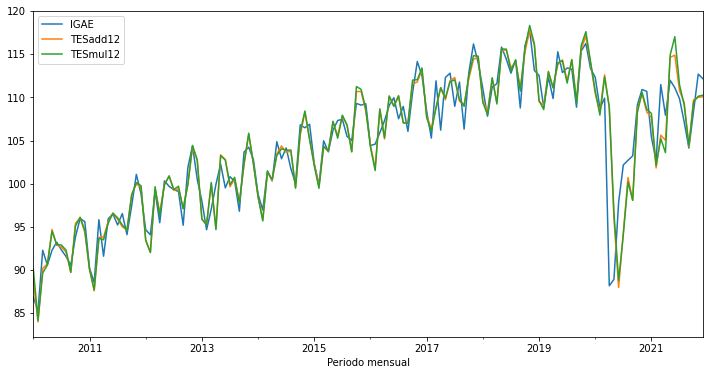

In [ ]:
IGAE[['IGAE','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

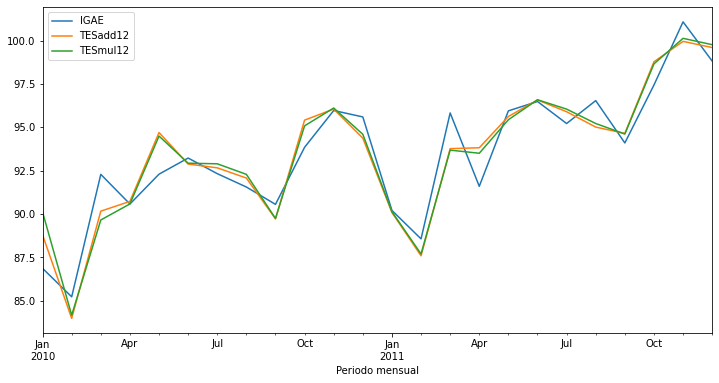

In [ ]:
IGAE[['IGAE','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Según el gráfico anterior, podría pensarse que el suavizado exponencial triple hace un trabajo de ajuste peor que el suavizado exponencial doble. La clave aquí es considerar lo que viene a continuación: el pronóstico. Veremos que tener la capacidad de predecir patrones estacionales fluctuantes mejora enormemente nuestro pronóstico.

## pronóstico

In [ ]:
#volvemos a estimar los modelos, pero guardandolos en un objeto
modelo_DESadd12 = ExponentialSmoothing(IGAE['IGAE'], trend='add').fit()
modelo_TESmul12 = ExponentialSmoothing(IGAE['IGAE'],trend='mul',seasonal='mul',seasonal_periods=12).fit()


una vez guardados, hacemos el pronóstico


In [ ]:
pronostico_DESadd12 = modelo_DESadd12.forecast(36).rename('predicción DES')
pronostico_TESmul12 = modelo_TESmul12.forecast(36).rename('predicción TES')


ahora graficamos


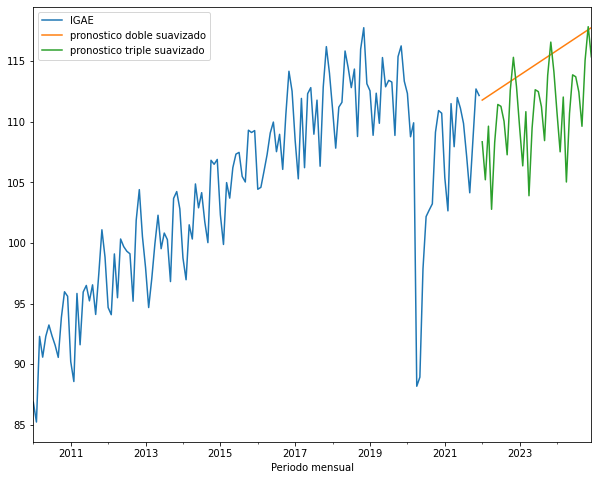

In [ ]:
IGAE['IGAE'].plot(figsize=(10,8));
pronostico_DESadd12.plot(label ='pronostico doble suavizado');
pronostico_TESmul12.plot(label ='pronostico triple suavizado');
plt.legend(loc = 'upper left')


Obviamente como el modelo de doble suavizamiento exponencial (DES) solo contempla la tendencia, el pronóstico es la tendencia

el modelo de triple suavizado exponencial (TES) considera el factor estacional, pronóstica considerando el efecto estacional